In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = tf.keras.datasets.fashion_mnist

In [15]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
y_train.shape

(60000,)

In [6]:
y_train[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

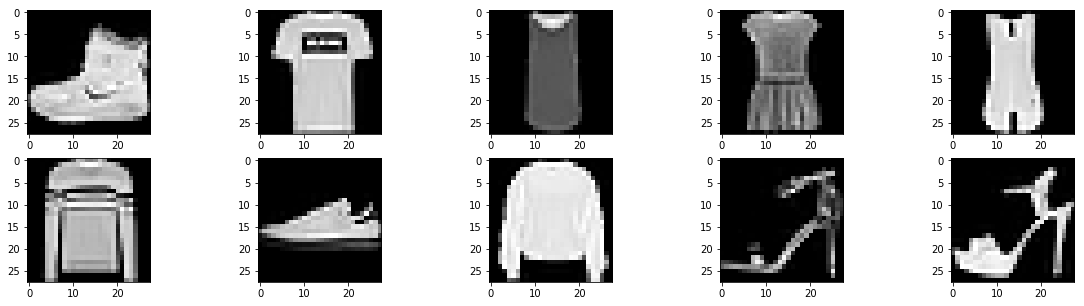

[9 0 0 3 0 2 7 2 5 5]


In [7]:
fig, axes = plt.subplots(2, 5, figsize=(20, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_train[i], cmap='gray')
    
plt.show()
print(y_train[:10])

In [9]:
X_train.min()

0

In [10]:
def img_preprocess(X):
    X = X/255.
    X = X.reshape(len(X), -1)
    return X

In [14]:
def onehot_enc(y):
    onehot = np.zeros((len(y), 10))
    onehot[np.arange(len(y)), y] = 1
    return onehot

In [16]:
X_train = img_preprocess(X_train)
X_test = img_preprocess(X_test)

y_train = onehot_enc(y_train)
y_test = onehot_enc(y_test)

In [17]:
y_test[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [51]:
tf.reset_default_graph()

inputs = tf.placeholder(dtype=tf.float32, shape=(None, 784), name='x')
labels = tf.placeholder(dtype=tf.float32, shape=(None, 10), name='y')

# with tf.variable_scope('hidden_layer'):
w1 = tf.Variable(tf.truncated_normal([784, 128]), name='w1')
b1 = tf.Variable(tf.zeros(128), name='b1')
z1 = tf.matmul(inputs, w1) + b1
a1 = tf.nn.relu(z1)
#     a1 = tf.layers.dense(inputs=inputs, units=128, activation=tf.nn.relu, name='w1')

# with tf.variable_scope('output_layer'):
w2 = tf.Variable(tf.truncated_normal([128, 10]), name='w2')
b2 = tf.Variable(tf.zeros(10), name='b2')
z2 = tf.matmul(a1, w2) + b2
#     z2 = tf.layers.dense(inputs=a1, units=10, name='w2')
    
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=z2), name='loss')
optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(loss)

predict_booling = tf.equal(tf.argmax(labels, axis=1), tf.argmax(z2, axis=1))
accuracy = tf.reduce_mean(tf.cast(predict_booling, tf.float32))

In [52]:
writer = tf.summary.FileWriter('Tensorboard/', graph=tf.get_default_graph())

In [33]:
loss

<tf.Tensor 'loss:0' shape=() dtype=float32>

In [40]:
tf.global_variables()

[<tf.Variable 'hidden_layer/w1/kernel:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'hidden_layer/w1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'output_layer/w2/kernel:0' shape=(128, 10) dtype=float32_ref>,
 <tf.Variable 'output_layer/w2/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'hidden_layer/w1/kernel/Adam:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'hidden_layer/w1/kernel/Adam_1:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'hidden_layer/w1/bias/Adam:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'hidden_layer/w1/bias/Adam_1:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'output_layer/w2/kernel/Adam:0' shape=(128, 10) dtype=float32_ref>,
 <tf.Variable 'output_layer/w2/kernel/Adam_1:0' shape=(128, 10) dtype=float32_ref>,
 <tf.Variable 'output_layer/w2/bias/Adam:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'out

In [36]:
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

In [42]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 10
batch_size = 32

total_batch = len(X_train)//batch_size

for epoch in tqdm_notebook(range(epochs)):
    for i in range(total_batch):
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        y_batch = y_train[i*batch_size:(i+1)*batch_size]
        sess.run(train_step, feed_dict={inputs:X_batch, labels:y_batch})
        
    X_train, y_train = shuffle(X_train, y_train)
    
    train_acc = sess.run(accuracy, feed_dict={inputs:X_train, labels:y_train})
    test_acc = sess.run(accuracy, feed_dict={inputs:X_test, labels:y_test})
    print('epoch {}, train_acc: {:.3f}, test_acc: {:.3f}'.format(epoch, train_acc, test_acc))

epoch 0, train_acc: 0.860, test_acc: 0.843
epoch 1, train_acc: 0.883, test_acc: 0.862
epoch 2, train_acc: 0.890, test_acc: 0.870
epoch 3, train_acc: 0.887, test_acc: 0.865
epoch 4, train_acc: 0.903, test_acc: 0.878
epoch 5, train_acc: 0.903, test_acc: 0.876
epoch 6, train_acc: 0.909, test_acc: 0.876
epoch 7, train_acc: 0.907, test_acc: 0.877
epoch 8, train_acc: 0.907, test_acc: 0.870
epoch 9, train_acc: 0.917, test_acc: 0.882



In [41]:
sess.close()

In [45]:
tf.reset_default_graph()

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(784,)),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/10
60000/60000 [==============================] - 4s 62us/step - loss: 0.5004 - acc: 0.8238
Epoch 2/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.3757 - acc: 0.8643
Epoch 3/10
60000/60000 [==============================] - 4s 60us/step - loss: 0.3392 - acc: 0.8767
Epoch 4/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.3128 - acc: 0.8845
Epoch 5/10
60000/60000 [==============================] - 4s 60us/step - loss: 0.2937 - acc: 0.8910
Epoch 6/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.2807 - acc: 0.8972
Epoch 7/10
60000/60000 [==============================] - 4s 60us/step - loss: 0.2688 - acc: 0.9005
Epoch 8/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.2564 - acc: 0.9048
Epoch 9/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.2486 - acc: 0.9070
Epoch 10/10
60000/60000 [==============================] - 4s 60us/step - loss: 0.2371 - acc: 0.9120

In [47]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 24us/step


[0.3579446482658386, 0.8776]

In [48]:
tf.global_variables()

[<tf.Variable 'dense/kernel:0' shape=(784, 128) dtype=float32>,
 <tf.Variable 'dense/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'dense_1/kernel:0' shape=(128, 10) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32>,
 <tf.Variable 'Adam/iterations:0' shape=() dtype=int64>,
 <tf.Variable 'Adam/lr:0' shape=() dtype=float32>,
 <tf.Variable 'Adam/beta_1:0' shape=() dtype=float32>,
 <tf.Variable 'Adam/beta_2:0' shape=() dtype=float32>,
 <tf.Variable 'Adam/decay:0' shape=() dtype=float32>,
 <tf.Variable 'training/Adam/Variable:0' shape=(784, 128) dtype=float32>,
 <tf.Variable 'training/Adam/Variable_1:0' shape=(128,) dtype=float32>,
 <tf.Variable 'training/Adam/Variable_2:0' shape=(128, 10) dtype=float32>,
 <tf.Variable 'training/Adam/Variable_3:0' shape=(10,) dtype=float32>,
 <tf.Variable 'training/Adam/Variable_4:0' shape=(784, 128) dtype=float32>,
 <tf.Variable 'training/Adam/Variable_5:0' shape=(128,) dtype=float32>,
 <tf.Variable 'training/Adam/Variable_6:0'